In [288]:
import os
import pandas
import numpy as np
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

## Pré-processamento
Etapa de seleção das colunas que carregam informações relevantes ao treinamento.

A fim de diminuir a dimensão do dataset, diversos filtros serão aplicados.

In [289]:
input_cols = [
    'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
        'TP_COR_RACA', 'TP_NACIONALIDADE', 'SG_UF_NASCIMENTO', 
        'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
    'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA',
    'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA',
    'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q024', 'Q025', 'Q026', 'Q027']

output_cols = ['NU_NOTA_REDACAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']

In [290]:
import zipfile
from os.path import abspath, join

root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')
# set dataset files path
file_path = join(dataset_dir, 'microdados_enem2018.zip')
# read zip files
zf = zipfile.ZipFile(file_path)
data = pandas.read_csv(zf.open('DADOS/MICRODADOS_ENEM_2018.csv'),
                       sep=';', encoding='cp1252', usecols=input_cols + output_cols)\
            .dropna()

### DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
O questionário socioeconômico possui informações categóricas que serão codificadas através do one-hot-encoding. Em casos especiais que a resposta é binária, os dados serão mapeados em 0 e 1.

|Coluna|Valores |
|:----:|:----:|
|Q001,Q002|A-H|
|Q003,Q004|                  A-F|
|Q005|                       1-20 (Numérico)|
|Q006|                       A-Q|
|Q007,Q026|                  A-D|
|Q008-17,Q019,Q022,Q024|     A-E|
|Q018,Q020-21,Q023,Q025|     A-B  (Codificação A=0, B=1)|
|Q027|                       A-F|


In [291]:
one_hot_socio = ['Q001','Q002','Q003','Q004','Q006',
         'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
         'Q015','Q016','Q017','Q019','Q022','Q024','Q026','Q027',
        ]
encode_socio = {
    'Q018':{'A':0,'B':1},
    'Q020':{'A':0,'B':1},
    'Q021':{'A':0,'B':1},
    'Q023':{'A':0,'B':1},
    'Q025':{'A':0,'B':1}}

#### Filtragem
A alternativa "Não sei." das questões Q001, Q002, Q003 e Q004 a princípio não traz tanta informação a cerca da situação socioeconômica do candidato. Devido aos recursos computacionais limitados, tais linhas do dataset serão eliminadas.

|Coluna|Opção "Não sei."|
|:----:|:----:|
|Q001|H|
|Q002|H|
|Q003|F|
|Q004|F|

In [292]:
print('Antes {}'.format(data.shape))
data.drop(data[(data['Q001']=="H") | (data['Q002']=="H")|(data['Q003']=="F") | (data['Q004']=="F")].index, inplace=True)
print('Depois {}'.format(data.shape))

Antes (2318389, 49)
Depois (1812629, 49)


### DADOS DO PARTICIPANTE
Sesão utilizadas as seguintes informações referentes ao participante:

|Coluna|Descrição|
|:----:|:---------|
|NU_IDADE|	Idade|
|TP_SEXO|	Sexo|
|TP_ESTADO_CIVIL|	Estado Civil|
|TP_COR_RACA|	Cor/raça|
|TP_NACIONALIDADE|	Nacionalidade|
|SG_UF_RESIDENCIA|	Sigla da Unidade da Federação de residência|
|SG_UF_NASCIMENTO|	Sigla da Unidade da Federação de nascimento|
|TP_ST_CONCLUSAO|	Situação de conclusão do Ensino Médio|
|TP_ANO_CONCLUIU|	Ano de Conclusão do Ensino Médio 1-12|
|TP_ESCOLA|	Tipo de escola do Ensino Médio 1-4|
|TP_ENSINO|	Tipo de instituição que concluiu ou concluirá o Ensino Médio 1-3|
|IN_TREINEIRO|	Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos 0-1|

Para diminuir a matrix final, as seguintes colunas foram ignoradas:

|Coluna|Descrição|
|:----:|:---------|
|NO_MUNICIPIO_RESIDENCIA|	Nome do município de residência|
|NO_MUNICIPIO_NASCIMENTO|	Nome do município de nascimento|

Serão avaliados apenas participantes do estado de São Paulo.

|Coluna|Valor|
|:----:|:---------|
|SG_UF_RESIDENCIA|SP|

In [293]:
one_hot_participante = [
    'SG_UF_RESIDENCIA','NU_IDADE',
    'TP_ESTADO_CIVIL','TP_COR_RACA',
    'SG_UF_NASCIMENTO','TP_NACIONALIDADE',
    'TP_ST_CONCLUSAO','TP_ANO_CONCLUIU','TP_ESCOLA','TP_ENSINO','IN_TREINEIRO'
]

encode_participante = {'TP_SEXO':{'M':0, 'F':1}}

#### Filtragem
Informações referentes aos municípios serão removidas pois ao serem codificadas pelo one-hot-encode produzem matrizes de dimensões elevadas.

Serão removidos do dataset linhas que não trazem informações relevantes ao classificados, tais como:

|Coluna|Valor|Descrição|
|:----:|:---:|:-------:|
|TP_NACIONALIDADE|0|Não informado|

Todos os participantes que fizeram a prova para treinar os conhecimentos serão removidos do dataset:

|Coluna|Valor|Descrição|
|:----:|:---:|:-------:|
|IN_TREINEIRO|1|Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos.|




In [294]:
print('Antes {}'.format(data.shape))

if 'NO_MUNICIPIO_RESIDENCIA' in data.columns:
    data.drop(['NO_MUNICIPIO_RESIDENCIA'], axis=1, inplace=True)
if 'NO_MUNICIPIO_NASCIMENTO' in data.columns:
    data.drop(['NO_MUNICIPIO_NASCIMENTO'], axis=1, inplace=True)

if 'IN_TREINEIRO' in data.columns:
    data.drop(data[data['IN_TREINEIRO']==1].index, inplace=True)
    data.drop(['IN_TREINEIRO'], axis=1, inplace=True)
    
if 'SG_UF_RESIDENCIA' in data.columns:
    data.drop(data[data['SG_UF_RESIDENCIA']!="SP"].index, inplace=True)
    data.drop(['SG_UF_RESIDENCIA'], axis=1, inplace=True)
    
data.drop(data[(data['TP_NACIONALIDADE']==0)].index, inplace=True)    
print('Depois {}'.format(data.shape))
    


Antes (1812629, 49)
Depois (289542, 47)


### Recursos Especializados
#### Filtragem

Removida as colunas:

|Coluna|Descrição|
|:----:|:-------:|
|IN_SEM_RECURSO|Indicador de inscrito que não requisitou nenhum recurso|



In [295]:
if 'IN_SEM_RECURSO' in data.columns:
    data.drop(['IN_SEM_RECURSO'], axis=1, inplace=True)
    

### DADOS DA PROVA OBJETIVA

Participantes que não são considerados presentes serão descartados.

|Coluna|Descrição|
|:-----:|:------:|
|TP_PRESENCA_CN|	Presença na prova objetiva de Ciências da Natureza|
|TP_PRESENCA_CH|	Presença na prova objetiva de Ciências Humanas|
|TP_PRESENCA_LC|	Presença na prova objetiva de Linguagens e Códigos|
|TP_PRESENCA_MT|	Presença na prova objetiva de Matemática|

Será aplicada uma função de conversão no valor médio das notas do participante. É objetivo do classificador
apresentar uma visão geral da performance do candidato.

|Coluna|Descrição|
|:-----:|:------:|
|NU_NOTA_CN|	Nota da prova de Ciências da Natureza|
|NU_NOTA_CH|	Nota da prova de Ciências Humanas|
|NU_NOTA_LC|	Nota da prova de Linguagens e Códigos|
|NU_NOTA_MT|	Nota da prova de Matemática|
|NU_NOTA_REDACAO|	Nota da prova de redação|

Aplicando a seguinte conversão:

Conceito|Faixa de nota correspondente
------------|-------------------------
A 	| Entre 600 e 1000, "Acima da média"
B 	| Abaixo de 600   "Abaixo da média"

In [296]:
one_hot_prova = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

In [297]:
def encode_nota(val):
    if val >= 600:
        return 'A'
    else:
        return 'B'

In [298]:
print('Filtro de presença')
print('Antes {}'.format(data.shape))
for p in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']:
    if p in data.columns:
        data.drop(data[(data[p]!=1)].index, inplace=True) # Só fica que foi
        data.drop([p], axis=1, inplace=True) # Apaga coluna
    else:
        print('Column {} do not exists.'.format(p))
print('Depis{}'.format(data.shape))    

Filtro de presença
Antes (289542, 46)
Depis(289542, 42)


In [299]:
## Nota média total
data['NU_NOTA_TOTAL'] = (data['NU_NOTA_REDACAO'] + data['NU_NOTA_CN'] +\
                         data['NU_NOTA_CH'] + data['NU_NOTA_LC'] + data['NU_NOTA_MT'])/5.

### Colunas utilizadas no classificador

In [300]:
data.columns

Index(['NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
       'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF',
       'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
       'Q007', 'Q024', 'Q025', 'Q026', 'Q027', 'NU_NOTA_TOTAL'],
      dtype='object')

## Histograma das notas do ENEM

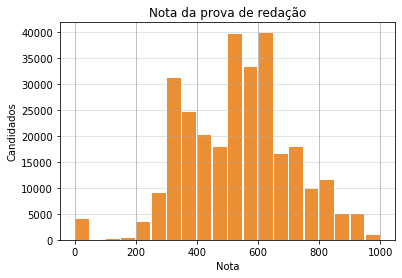

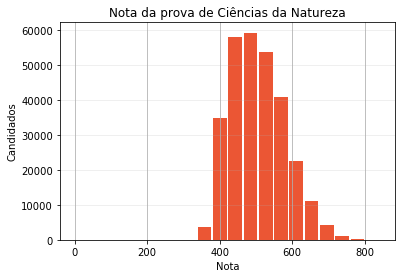

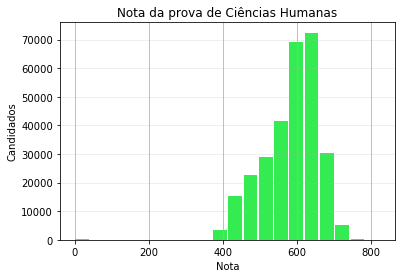

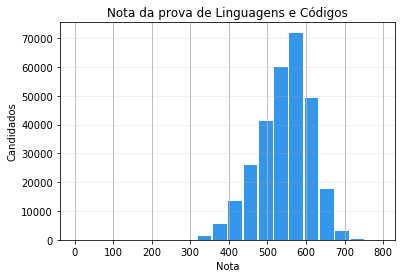

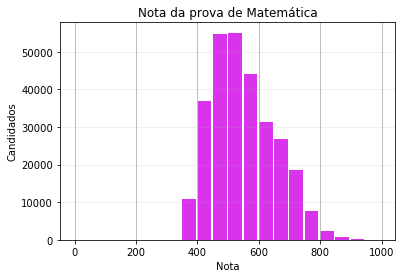

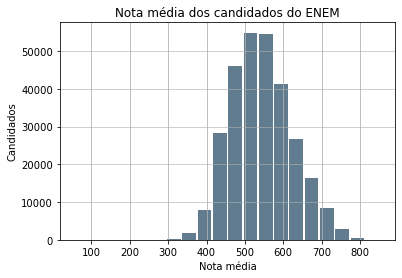

In [301]:
data['NU_NOTA_REDACAO'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#eb8f34')
plt.title('Nota da prova de redação')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.45)
plt.show()

data['NU_NOTA_CN'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#eb5634')
plt.title('Nota da prova de Ciências da Natureza')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()

data['NU_NOTA_CH'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#34eb52')
plt.title('Nota da prova de Ciências Humanas')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()


data['NU_NOTA_LC'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#3496eb')
plt.title('Nota da prova de Linguagens e Códigos')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()


data['NU_NOTA_MT'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#d934eb')
plt.title('Nota da prova de Matemática')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()



data['NU_NOTA_TOTAL'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Nota média dos candidados do ENEM')
plt.xlabel('Nota média')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [302]:
data['NU_NOTA_CN'].max()

843.0

Estou interessado em uma visão geral da nota do aluno
Se por algum motivo ele não fez a prova o dado não é válido para mim

In [306]:
## Nota média total
data['NU_NOTA_TOTAL'] = (data['NU_NOTA_REDACAO'] + data['NU_NOTA_CN'] +\
                         data['NU_NOTA_CH'] + data['NU_NOTA_LC'] + data['NU_NOTA_MT'])/5.

# MLP

In [307]:
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report

from keras.models import Sequential
from keras.utils import np_utils
from keras.regularizers import l1_l2
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


## Divisão do dataset

|Tipo|Amostras|
|::|::|
|Treino|169416|
|Teste|70591|
|Validação|42354|


In [318]:
def get_model(neurons=30,dropout=0.1):
    model = Sequential()
    kernel_initializer='uniform'
    optimizer='adam'
    
    # Camada Entrada
    model.add(Dense(neurons, input_dim=df_inp_train.shape[1], kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
 
    model.add(Dense(neurons, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
  
    # Camada Saída
    model.add(Dense(output_dim=1, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model


### Busca de hiperparâmetros
Será feita uma busca pelos melhores hiperparâmetros para o modelo. A métrica escolhida será a acurácia.

|Hiperparâmetro|Valores|
|:------------:|:------:|
|Neurônios|1, 5, 10, 15, 20, 25, 30, 50|
|Dropout|0.1, 0.15, 0.25|

#### Características do modelo

|||
|:-----:|:------:|
|Otimizador|Adam|
|Camadas escondidas|2|
|Função de ativação, camdas escondidas|relu|
|Função de ativação, camada de saída|softmax|
|Função de custo|binary_crossentropy|
|Inicialização dos pesos|uniform|




In [314]:
one_hot_cols = set(data.columns).intersection(one_hot_socio + one_hot_participante + one_hot_prova)
input_cols_ = set(input_cols).intersection(data.columns)

# Dataframe de entrada
df_inp = pandas.get_dummies(data[input_cols_], 
                   columns=set(one_hot_cols).intersection(input_cols_)
           ).replace({**encode_participante, **encode_socio})

# Dataframe de saída
df_out = data['NU_NOTA_TOTAL'].apply(encode_nota)

# Para usar o GridSearch não suport one-hot-encoding
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()
df_out = lc.fit_transform(df_out)

df_inp_train, df_inp_test, df_out_train, df_out_test = \
    train_test_split(df_inp,df_out, test_size=0.25, random_state=1)

df_inp_train, df_inp_val, df_out_train, df_out_val = \
    train_test_split(df_inp_train, df_out_train, test_size=0.20, random_state=1)

for col in df_inp.columns:
    if df_inp[col].dtype != 'uint8' and df_inp[col].dtype != 'int64':
        print(col, df_inp[col].dtype)

In [319]:
# create model 
keras_model = KerasClassifier(build_fn=get_model, epochs=50, batch_size=1000)
 
# define the grid search parameters
param_grid = {
    'neurons':[1, 5, 10, 15, 20, 25, 30, 50],
    'dropout':[0.1, 0.15, 0.25]
}

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, verbose=1, n_jobs=-1, cv=5, scoring='accuracy')

grid_result = grid.fit(df_inp_train, df_out_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 62 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:  9.7min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.7min finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", units=1)`
  app.launch_new_instance()


Epoch 1/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.5349 - accuracy: 0.6978
Epoch 2/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4754 - accuracy: 0.7185
Epoch 3/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4708 - accuracy: 0.7220
Epoch 4/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4691 - accuracy: 0.7226
Epoch 5/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4687 - accuracy: 0.7224
Epoch 6/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4674 - accuracy: 0.7245
Epoch 7/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4673 - accuracy: 0.7240
Epoch 8/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4673 - accuracy: 0.7242
Epoch 9/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4675 - accuracy: 0.7223
Epoch 10/50
173724/173724 [==========

#### Resultados da busca por hiperparâmetros

O melhort conjunto para a busca, com k-fold cross validation de 5 folds apresentou acurácia de acurácia 0.701616.

* Dropout 0.25
* Neurônios por camada 25
* Épocas 50
* Batch 1000

In [320]:
# summarize results
print("Melhor: acurácia %f com %s\n\n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) com: %r" % (mean, stdev, param))

Melhor: acurácia 0.810280 com {'dropout': 0.15, 'neurons': 25}


0.766653 (0.001841) com: {'dropout': 0.1, 'neurons': 1}
0.808984 (0.001621) com: {'dropout': 0.1, 'neurons': 5}
0.809882 (0.001074) com: {'dropout': 0.1, 'neurons': 10}
0.809802 (0.001918) com: {'dropout': 0.1, 'neurons': 15}
0.809980 (0.001464) com: {'dropout': 0.1, 'neurons': 20}
0.809848 (0.000985) com: {'dropout': 0.1, 'neurons': 25}
0.809664 (0.001279) com: {'dropout': 0.1, 'neurons': 30}
0.808115 (0.001200) com: {'dropout': 0.1, 'neurons': 50}
0.766653 (0.001841) com: {'dropout': 0.15, 'neurons': 1}
0.809128 (0.001966) com: {'dropout': 0.15, 'neurons': 5}
0.809623 (0.000703) com: {'dropout': 0.15, 'neurons': 10}
0.809917 (0.000863) com: {'dropout': 0.15, 'neurons': 15}
0.809589 (0.001190) com: {'dropout': 0.15, 'neurons': 20}
0.810280 (0.000965) com: {'dropout': 0.15, 'neurons': 25}
0.809577 (0.001278) com: {'dropout': 0.15, 'neurons': 30}
0.808484 (0.000906) com: {'dropout': 0.15, 'neurons': 50}
0.766653 (0.001841)

### Treinamento com Keras

In [321]:
keras_model = get_model(neurons=25, dropout=0.15)
epochs=50
batch_size=1000

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", units=1)`
  app.launch_new_instance()


In [322]:
model = get_model()
callbacks = [
    ModelCheckpoint('mlp-neurons'),
                    monitor='val_loss', save_best_only=True, verbose=1)
]
print("Training...")
history = model.fit(df_inp_train, df_out_train, validation_data=(df_inp_val, df_out_val),\
    callbacks=callbacks, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, use_multiprocessing=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", units=1)`
  app.launch_new_instance()


Training...
Train on 173724 samples, validate on 43432 samples
Epoch 1/50
173724/173724 [==============================] - 2s 14us/step - loss: 0.5133 - accuracy: 0.7319 - val_loss: 0.4335 - val_accuracy: 0.8086

Epoch 00001: val_loss improved from inf to 0.43348, saving model to mlp-neurons-[10]-init-uniform
Epoch 2/50
173724/173724 [==============================] - 2s 12us/step - loss: 0.4592 - accuracy: 0.7489 - val_loss: 0.4297 - val_accuracy: 0.8104

Epoch 00002: val_loss improved from 0.43348 to 0.42966, saving model to mlp-neurons-[10]-init-uniform
Epoch 3/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4566 - accuracy: 0.7504 - val_loss: 0.4272 - val_accuracy: 0.8107

Epoch 00003: val_loss improved from 0.42966 to 0.42718, saving model to mlp-neurons-[10]-init-uniform
Epoch 4/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4555 - accuracy: 0.7514 - val_loss: 0.4269 - val_accuracy: 0.8122

Epoch 00004: val_loss improved from


Epoch 00038: val_loss did not improve from 0.42354
Epoch 39/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4462 - accuracy: 0.7560 - val_loss: 0.4280 - val_accuracy: 0.8102

Epoch 00039: val_loss did not improve from 0.42354
Epoch 40/50
173724/173724 [==============================] - 2s 14us/step - loss: 0.4457 - accuracy: 0.7561 - val_loss: 0.4273 - val_accuracy: 0.8108

Epoch 00040: val_loss did not improve from 0.42354
Epoch 41/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4446 - accuracy: 0.7590 - val_loss: 0.4251 - val_accuracy: 0.8112

Epoch 00041: val_loss did not improve from 0.42354
Epoch 42/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4455 - accuracy: 0.7571 - val_loss: 0.4256 - val_accuracy: 0.8114

Epoch 00042: val_loss did not improve from 0.42354
Epoch 43/50
173724/173724 [==============================] - 2s 13us/step - loss: 0.4452 - accuracy: 0.7566 - val_loss: 0.4248 - val_accurac

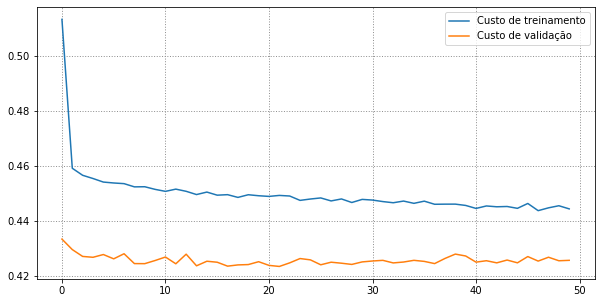

In [333]:
fig = plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(history.history['loss'], label='Custo de treinamento')
plt.plot(history.history['val_loss'], label='Custo de validação')
plt.grid(True)
plt.legend()
fig.savefig('mlp_history.png', dpi=600)
plt.show()


#### Parada prematura
Os pesos utilizados são referentes à época 14, que apresentou menor valor para a função de custo no treinamento 0.4505 e validação 0.4254.

A acurácia para o dataset de treinamento foi 0.7533 enquanto para o dataset de validação 0.8119.


In [335]:
model.load_weights('mlp-neurons-[10]-init-uniform')
class_pred = model.predict_classes(df_inp_test)
print(classification_report(df_out_test, class_pred))

              precision    recall  f1-score   support

           0       0.67      0.38      0.48     16903
           1       0.83      0.94      0.88     55483

    accuracy                           0.81     72386
   macro avg       0.75      0.66      0.68     72386
weighted avg       0.79      0.81      0.79     72386

